### Estimate the superconducting penetration depth of $\beta$-Ta

In [25]:
from pathlib import Path
import corner
import lmfit
import numpy as np
from scipy.constants import mu_0
from uncertainties import ufloat

from betata import plt
import matplotlib.ticker as ticker
from betata.resonator_studies.resonator import (
    Resonator,
    load_resonators,
    save_resonator,
)

BTA_COLOR = "#762A83"

# assign a more reasonable-ish uncertainty for N_sq
SIM_UNCERTAINTY = 0.05
# assign a reasonable-ish uncertainty for film thickness
THICKNESS_UNCERTAINTY = 0.05

CWD = Path.cwd()

Define helper functions to calculate and save sheet inductances for all resonators

In [2]:
def find_sheet_inductance(l_kin, n_sq) -> ufloat:
    """ """
    return l_kin / n_sq

def save_resonator_sheet_inductance():
    resonators: list[Resonator] = load_resonators()
    for resonator in resonators:
        if None not in [resonator.l_kin, resonator.l_kin_err, resonator.N_sq, resonator.N_sq_err]:
            u_l_kin = ufloat(resonator.l_kin, resonator.l_kin_err)
            u_n_sq = ufloat(resonator.N_sq, SIM_UNCERTAINTY * resonator.N_sq + resonator.N_sq_err)

            u_l_sheet = find_sheet_inductance(u_l_kin, u_n_sq)

            resonator.l_sheet = u_l_sheet.n
            resonator.l_sheet_err = u_l_sheet.s

            save_resonator(resonator)

In [3]:
save_resonator_sheet_inductance()

Load resonators and extract thickness and sheet inductance data

In [4]:
resonators = load_resonators()

In [5]:
# only use CPWs for this subfigure
thicknesses = []
l_sheets = []
l_sheet_errs = []
for resonator in resonators:
    l_kin, n_sq, n_sq_err = resonator.l_kin, resonator.N_sq, resonator.N_sq_err
    if resonator.type == "CPW" and None not in [l_kin, n_sq, n_sq_err]:
        thicknesses.append(resonator.film_thickness)
        l_sheets.append(resonator.l_sheet)
        l_sheet_errs.append(resonator.l_sheet_err)
thicknesses = np.array(thicknesses)
sort_idx = np.argsort(thicknesses)
thicknesses = thicknesses[sort_idx]
thickness_errs = thicknesses * THICKNESS_UNCERTAINTY
l_sheets = np.array(l_sheets)[sort_idx]
l_sheet_errs = np.array(l_sheet_errs)[sort_idx]

Do initial fit

In [6]:
def pen_depth_fit_fn(x, pen_depth):
    """ """
    return (mu_0 * pen_depth) / np.tanh(x / pen_depth)

In [7]:
fit_result = lmfit.Model(pen_depth_fit_fn).fit(
    l_sheets,
    x=thicknesses,
    weights=l_sheet_errs,
    pen_depth=1.63e-6,
)
print(fit_result.fit_report())

[[Model]]
    Model(pen_depth_fit_fn)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 80
    # variables        = 1
    chi-square         = 1.3445e-42
    reduced chi-square = 1.7019e-44
    Akaike info crit   = -8061.56827
    Bayesian info crit = -8059.18624
    R-squared          = 0.99999012
[[Variables]]
    pen_depth:  2.0210e-06 +/- 6.9380e-09 (0.34%) (init = 1.63e-06)


Run MCMC to refine fit result

In [8]:
def pen_depth_error_fn(params, x, data, l_sheet_errs):
    """ """
    pen_depth = params["pen_depth"].value
    return (data - pen_depth_fit_fn(x, pen_depth)) / l_sheet_errs


In [12]:
emcee_kws = {
    "nwalkers": 250,
    "burn": 1000,
    "steps": 10000,
    "thin": 20,
    "is_weighted": False,
}

emcee_params = fit_result.params
emcee_params.add('__lnsigma', value=np.log(0.1), min=-np.inf, max=np.inf)
emcee_params["pen_depth"].min = 1e-7
emcee_params["pen_depth"].max = 1e-5


emcee_result = lmfit.minimize(
    pen_depth_error_fn,
    params=emcee_params,
    args=(thicknesses, l_sheets, l_sheet_errs),
    method="emcee",
    nan_policy="omit",
    **emcee_kws,
)

100%|██████████| 10000/10000 [00:39<00:00, 251.35it/s]


Make corner plot

Autocorrelation time for the parameters:
----------------------------------------
pen_depth = 30.067
__lnsigma = 48.440
Median of posterior probability distribution
--------------------------------------------
[[Variables]]
    pen_depth:  1.7751e-06 +/- 2.2609e-08 (1.27%) (init = 1.775481e-06)
    __lnsigma:  0.27897075 +/- 0.08015235 (28.73%) (init = -2.302585)


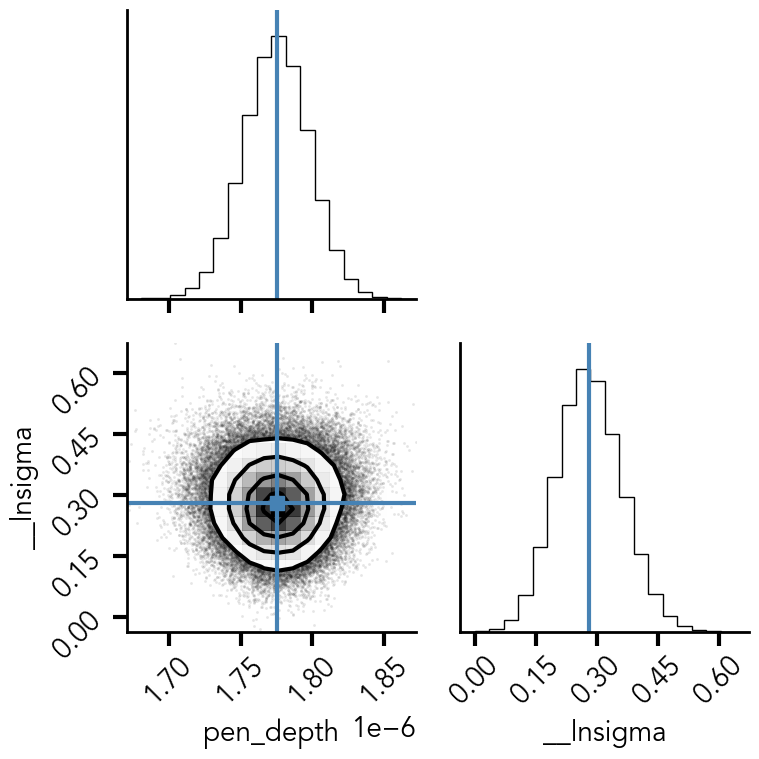

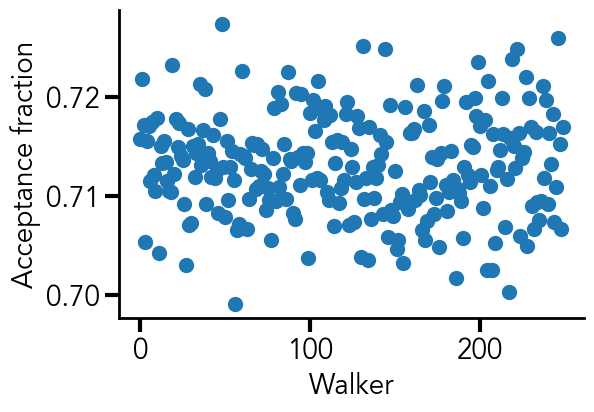

In [13]:
corner_fig = plt.figure(figsize=(8, 8))
emcee_plot = corner.corner(
    emcee_result.flatchain,
    labels=emcee_result.var_names,
    truths=list(emcee_result.params.valuesdict().values()),
    fig=corner_fig,
)
emcee_plot.tight_layout()

acc_frac_fig, acc_frac_ax = plt.subplots(figsize=(6, 4))
acc_frac_ax.plot(emcee_result.acceptance_fraction, 'o')
acc_frac_ax.set_xlabel('Walker')
acc_frac_ax.set_ylabel('Acceptance fraction')
if hasattr(emcee_result, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for i, p in enumerate(emcee_params):
        print(f'{p} = {emcee_result.acor[i]:.3f}')

print("Median of posterior probability distribution")
print("--------------------------------------------")
print(lmfit.fit_report(emcee_result.params))

highest_prob = np.argmax(emcee_result.lnprob)
hp_loc = np.unravel_index(highest_prob, emcee_result.lnprob.shape)
mle_soln = emcee_result.chain[hp_loc]
for i, par in enumerate(emcee_params):
    emcee_params[par].value = mle_soln[i]

In [14]:
final_pen_depth = ufloat(emcee_result.params["pen_depth"].value, emcee_result.params["pen_depth"].stderr)
print(f"Superconducting penetration depth λ: {final_pen_depth * 1e6:.2f} μm")

Superconducting penetration depth λ: 1.78+/-0.02 μm


Plot data and fit

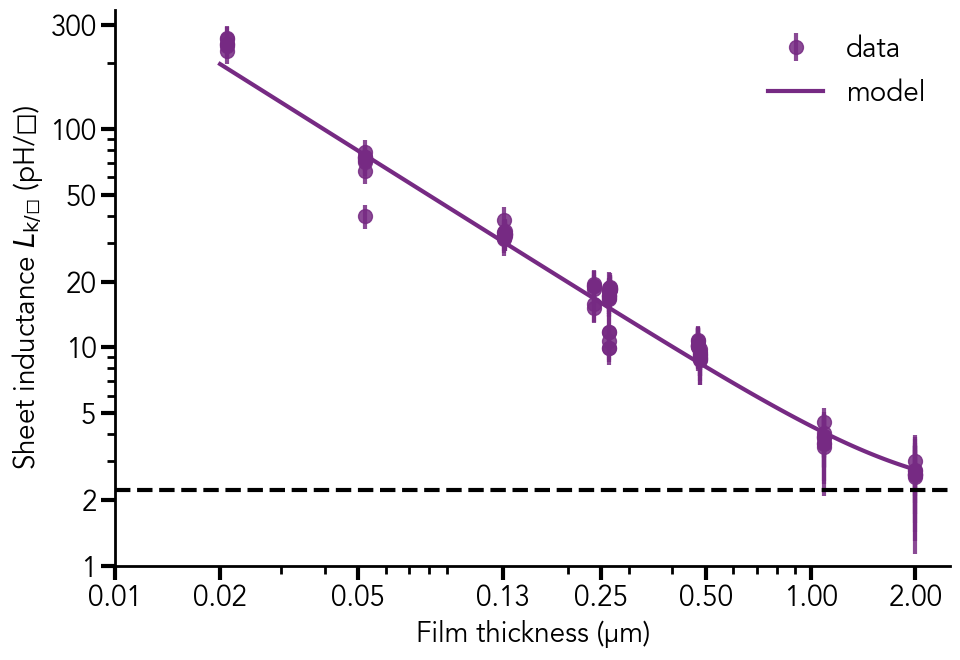

In [30]:
fig, ax = plt.subplots(figsize=(10, 7))

thicknesses_um = thicknesses * 1e6
thickness_errs_um = thickness_errs * 1e6
l_sheets_pH = l_sheets * 1e12
l_sheet_errs_pH = l_sheet_errs * 1e12

thicknesses_dummy_1 = np.linspace(20e-9, 2e-6, 101)
l_sheets_fit_pH_1 = pen_depth_fit_fn(thicknesses_dummy_1, final_pen_depth.n) * 1e12

ax.errorbar(
    thicknesses_um,
    l_sheets_pH,
    yerr=l_sheet_errs_pH,
    ls="",
    c=BTA_COLOR,
    marker="o",
    label="data",
    alpha=0.85,
)

ax.plot(
    thicknesses_dummy_1 * 1e6,
    l_sheets_fit_pH_1,
    color=BTA_COLOR,
    label="model",
)


l_sheet_saturated_pH = mu_0 * final_pen_depth.n * 1e12

ax.axhline(y=l_sheet_saturated_pH, color="k", linestyle='--')

ax.set_ylabel(r"Sheet inductance $L_\mathrm{k/◻}$ (pH/$◻$)")
ax.set_xlabel(r"Film thickness (μm)")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylim(1, 350)

ax.set_xticks([0.01, 0.02, 0.05, 0.13, 0.25, 0.5, 1.0, 2.0])
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

ax.set_yticks([1, 2, 5, 10, 20, 50, 100, 300])
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())

ax.legend(frameon=False, reverse=True)

fig.tight_layout()

figsavepath = CWD / "out/resonator_studies/penetration_depth.png"
plt.savefig(figsavepath, dpi=300, bbox_inches="tight")

plt.show()